# Project 4: West Nile Virus Prediction
---

## Predict West Nile virus in mosquitos across the city of Chicago

## Table of Contents (Part 2):

- [6. Final Dataset Preparation for Modelling](#6.-Final-Dataset-Preparation-for-Modelling)
- [7. Modeling](#7.-Modeling)    
    - [A. Base Case](#A.-Base-Case)
    - [B. Model: K Nearest Neighbors](#B.-Model:-K-Nearest-Neighbors)
    - [C. Model: Random Forest Classifier](#C.-Model:-Random-Forest-Classifier)
    - [D. Model: Multinomial Naive Bayes Model](#D.-Model:-Multinomial-Naive-Bayes-Model)
    - [E. Model: Logistic Regression](#E.-Model:-Logistic-Regression)
    - [F. Model: Decision Tree](#F.-Model:-Decision-Tree)  
    - [G. Final Model](#G.-Final-Model)
- [8. Cost Analysis](#8.-Cost-Analysis)
    - [A. Effects of Spraying on WNV](#A.-Effects-of-Spraying-on-WNV)
    - [B. Cost and Benefits of Spraying](#B.-Cost-and-Benefits-of-Spraying)
    - [C. Cost and Benefits Equation](#C.-Cost-and-Benefits-Equation)
- [9. Conclusion and Recommendations](#9.-Conclusion-and-Recommendations) 
    - [A. Model Conclusion](#A.-Model-Conclusion)
    - [B. Cost Benefit Analysis Conclusion](#B.-Cost-Benefit-Analysis-Conclusion)
    - [C. Recommendations](#C.-Recommendations)
- [10. References and Data Sources](#10.-References-and-Data-Sources) 

In [ ]:
# import libraries

import pandas as pd
import requests
import time
import random
import string
import scipy.stats as stats
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve, mean_squared_error

from imblearn.over_sampling import SMOTE

## 6. Final Dataset Preparation for Modelling
---

Based on the EDA on the weather dataset, we have concluded that the relevant factors are 'Tavg', 'DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir'. We will now combine these weather features with both our train and test dataset.

From our research on [Culex Lifecycles](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html) and a paper on how the [climate affects the West Nile Virus spread](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/), we have found out that temperature, humidity and rain affects multiple parts of a mosquito's lifecycle.

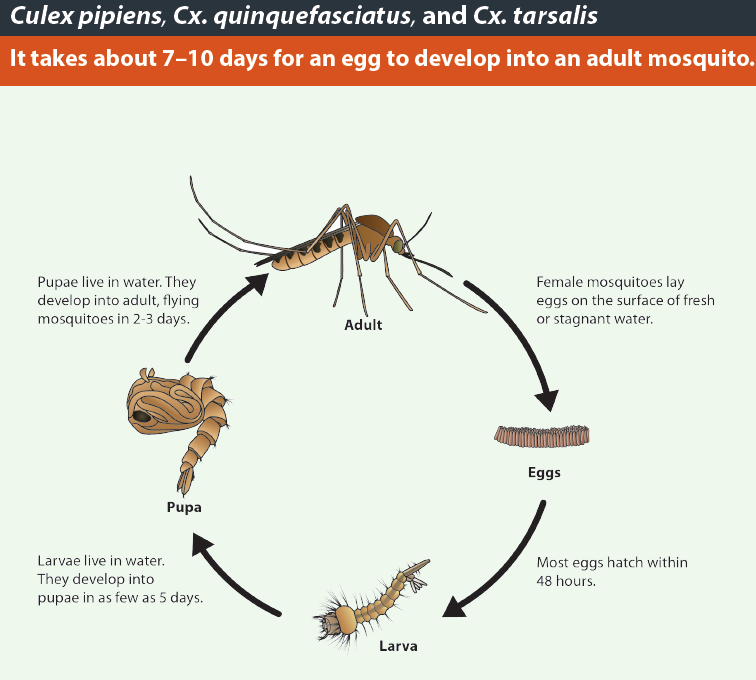

We can see that the mosquito's lifecycle spans from 7-10 days, from the eggs being laid then grown to larvae, pupae and then to becoming adult mosquitos.

For this reason, we will have to modify the weather data to be backward looking to take into account the events that occurred before the West Nile Virus was detected to see what the weather conditions were like during and before the identification of West Nile Virus. We will be exploring these features below and attempting to build a dataset that contains our train data and matching weather data.

From the data above, wind and air pressure only affects the mosquito at adult stage and these need not be lagged. Other features such as humidity, rain and temperature affect the other stages of a mosquito's life cycle.

In [ ]:
# We read in the cleaned datasets
test_clean = pd.read_csv('../DataSets/test_clean.csv')
train_clean = pd.read_csv('../DataSets/train_clean.csv')
weather_clean = pd.read_csv('../DataSets/weather_clean.csv')

In [ ]:
# We change the date column to datetime and set it as index
train_clean['Date'] = pd.to_datetime(train_clean['Date'])
train_clean.reset_index(drop=True,inplace=True)
train_clean.set_index('Date',inplace=True)

test_clean['Date'] = pd.to_datetime(test_clean['Date'])
test_clean.reset_index(drop=True,inplace=True)
test_clean.set_index('Date',inplace=True)

weather_clean['Date'] = pd.to_datetime(weather_clean['Date'])
weather_clean.reset_index(drop=True,inplace=True)
weather_clean.set_index('Date',inplace=True)

In [ ]:
# We merge the features that do not need to be lagged
train_final = train_clean.merge(weather_clean[['StnPressure', 'ResultSpeed', 'ResultDir']], left_index=True, right_index=True)
test_final = test_clean.merge(weather_clean[['StnPressure', 'ResultSpeed', 'ResultDir']], left_index=True, right_index=True)

We did some experiments on lagging weather features(DewPoint, Tavg and PrecipTotal).

First, we lagged each day's weather by one day up to 10 days and have each lagged day as a new variable. What we found is that features around the 3 to 5 day mark have the most significance when passed through a simple logistic regression.

Further experiment showed that rolling these features provided better results and as such, we rolled from a range of 2 to 6 days for each feature.

In [ ]:
# We create a seperate dfs for weather features we wish to roll

dew = weather_clean[['DewPoint']].copy()
dew['DewPoint_roll2'] = dew['DewPoint'].rolling(window=2).mean();
dew['DewPoint_roll3'] = dew['DewPoint'].rolling(window=3).mean();
dew['DewPoint_roll4'] = dew['DewPoint'].rolling(window=4).mean();
dew['DewPoint_roll5'] = dew['DewPoint'].rolling(window=5).mean();
dew['DewPoint_roll6'] = dew['DewPoint'].rolling(window=6).mean();

temp = weather_clean[['Tavg']].copy()
temp['Tavg_roll2'] = temp['Tavg'].rolling(window=2).mean();
temp['Tavg_roll3'] = temp['Tavg'].rolling(window=3).mean();
temp['Tavg_roll4'] = temp['Tavg'].rolling(window=4).mean();
temp['Tavg_roll5'] = temp['Tavg'].rolling(window=5).mean();
temp['Tavg_roll6'] = temp['Tavg'].rolling(window=6).mean();

precip = weather_clean[['PrecipTotal']].copy()
precip['PrecipTotal_roll2'] = precip['PrecipTotal'].rolling(window=2).mean();
precip['PrecipTotal_roll3'] = precip['PrecipTotal'].rolling(window=3).mean();
precip['PrecipTotal_roll4'] = precip['PrecipTotal'].rolling(window=4).mean();
precip['PrecipTotal_roll5'] = precip['PrecipTotal'].rolling(window=5).mean();
precip['PrecipTotal_roll6'] = precip['PrecipTotal'].rolling(window=6).mean();

In [ ]:
# We then merge
train_final = train_final.merge(dew, left_index=True, right_index=True)
test_final = test_final.merge(dew, left_index=True, right_index=True)

train_final = train_final.merge(temp, left_index=True, right_index=True)
test_final = test_final.merge(temp, left_index=True, right_index=True)

train_final = train_final.merge(precip, left_index=True, right_index=True)
test_final = test_final.merge(precip, left_index=True, right_index=True)

In [ ]:
train_final.shape

(8610, 198)

In [ ]:
# We save these files
train_final.to_csv('../DataSets/train_final.csv', index=False)
test_final.to_csv('../DataSets/test_final.csv', index=False)

## 7. Modeling
---

All the models were saved in different notebooks and placed in the 'model' subfolder. The models will read in the 'train_final.csv' and 'test_final.csv' files for their modeling. The results are summarised below. For more information on the various models, please refer to their respective notebooks.

## A. Base Case

### Evaluation

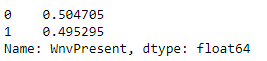

sm = SMOTE(sampling_strategy = {1: 8000}, random_state = 42)

Our accuracy score after SMOTE is 0.505. However since our metric is ROC_AUC, our baseline is 0.5 for the ROC_AUC.

## B. Model: K Nearest Neighbors

### Evaluation

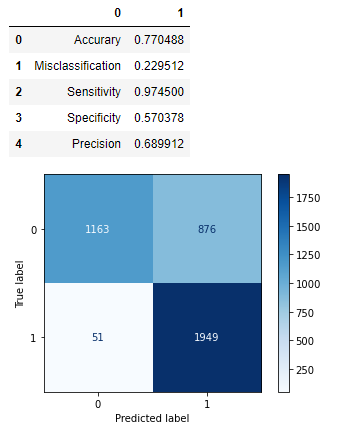

When submitted to kaggle, the score is **0.53941**.

When fitting the model to K Nearest Neighbors, the best parameters found were using n = 40 and distance being manhattan.
The best score for the train dataset was 0.6569 while the score for the holdout dataset was 0.6502.
When ran on test data, the score on kaggle was 0.53941. This shows that the model was weak and drastically overfitted.

Because KNN has a very limited concept of probability, its estimate is simply a fraction of votes amongst nearest neighbors. We can refine it by increasing n but our gridsearch showed that n = 40 was the optimal value. Should the kaggle metric be just simply classification of 1 and 0, our model might have done better in terms of accuracy. However, for such a case, this model was rather unsatisfactory. 

The other main weakness for KNN is that there is little intepretation we can do on the model. We are unable to determine feature importance or intepret coefficients.

## C. Model: Random Forest Classifier

### Evaluation

|                                                                                                                       | Train Set Accuracy Score | Val Set Accuracy Score | Train Set ROC-AUC Score | Val Set ROC-AUC Score | Kaggle Test Set Score (After refitting with full dataset) | Best Params                                                                                               |
|-----------------------------------------------------------------------------------------------------------------------|--------------------------|------------------------|-------------------------|-----------------------|-----------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| Model 1: 1st Run. GridSearch without Pipeline from Imblearn                                                           | 0.96                     | 0.938                  | 0.992                   | 0.848                 | 0.703                                                     | {'max_depth': 25, 'max_features': 0.3, 'min_samples_leaf': 10, 'min_samples_split': 6}                    |
| Model 2: GridSearch without Pipeline from Imblearn (Constrain the model using hyperparameters for fixing overfitting) | 0.742                    | 0.7                    | 0.742                   | 0.7                   | 0.59                                                      | {'ccp_alpha': 0.1, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 200, 'min_samples_split': 6} |
| Model 3: GridSearch using Pipeline from Imblearn                                                                      | 0.931                    | 0.926                  | 0.884                   | 0.854                 | 0.729                                                     | {'rt__max_depth': 15, 'rt__max_features': 0.1, 'rt__min_samples_leaf': 5, 'rt__min_samples_split': 6}     |
| Model 4: GridSearch using BalancedRandomForestClassifier                                                              | 0.696                    | 0.688                  | 0.85                    | 0.839                 | 0.694                                                     | {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 3}                     |

### Top features for model 3

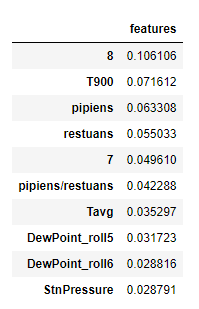

In model 1 and 2, without using the imbalance pipeline, we tried a couple of different hyperparameters within GridSearch but the resulting model is always overfitted since this is an imbalance class. GridSearch always return the hyperparameters that return the highest scoring but this doesn't help with overfitting. Even increasing the folds of crossvalidation doesn't helps here as the input to GridSearch is after using SMOTE where the minority class is oversampled and not an imbalanced class. 

The only way we can prevent overfitting is to manually capped some of the hyperparameters that prevent overfitting like 'max_depth', 'max_features', 'max_leaf_nodes', 'min_samples_leaf' and 'min_samples_split' and gridsearch over the rest of hyperparameters like 'n_estimators. In the end, we choose to keep the tree from overgrowing by capping max_depth and introducing ccp_alpha while gridsearching over the rest. In our attempt to prevent overfitting, we sacrificed alot on the ROC_AUC score as the gridsearch wasn't working and we weren't finding the correct hyperparameters.

In model 3, 4, we seek to GridSearch more meaningfully using the pipeline from imblearn library or using BalanceRandomForestClassifier which randomly under-samples each boostrap sample to balance it.. In both cases, we obtained models that give better results across all metrics compared to model2. The ROC_AUC scores for both the train and val set are also higher than model2. There was also no sign of overfitting. When we submit the result to Kaggle. Model3 achieve the highest Kaggle Score of 0.729 and Model4 0.694. Model3 and Model4 are more robust than Model1. Model3 metrics are better than Model4 and we conclude Model 3 as our best randomforestclassifier model.

## D. Model: Multinomial Naive Bayes Model

### Evaluation

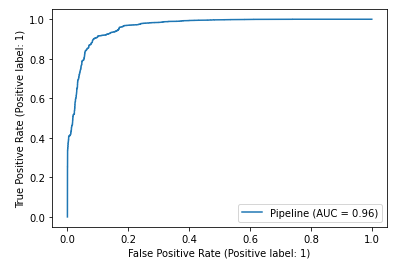

The Kaggle submission score for this Naive Bayes model is **0.71312**. 

Naive Bayes model tends to perform well when the input variables are categorical. Out of 166 input variables fed into this model, only 21 of those variables are numerical variables. The others are categorical variables. 

Naive Bayes model's main limitation is its assumption of independent predictors. This assumption is almost impossible to satisfy in reality as it is not possible to get a set of predictors that are completely independent. Moreover, looking at the top features of this model, there are some common features that are found to be important in predicting WNV, as well as, in predicting no WNV. For example, DewPoint_roll2, DewPoint_roll3 and Tavg are found to be common important features in predicting the positive and negative class. Even though, this model seems to perform reasonably well and has one of the highest ROC score compared to the other models tested, it may not be suitable for this project.

Additionally, the kaggle score is much lower than the ROC score for the train set (ROC score for train is 0.933). Thus, highlighting that there may be overfitting in the model.

The top 5 features for this model are DewPoint_roll2, DewPoint_roll3, Tavg, DewPoint and Tavg_roll2. This indicates that the weather features and the rolling weather features are strong predictors for this model.

## E. Model: Logistic Regression

### Evaluation

|        Model        	|                       Features used                       	|      Scaling     	|                               Best params                              	| Accuracy 	|  Roc  	| Kaggle score 	|
|:-------------------:	|:---------------------------------------------------------:	|:----------------:	|:----------------------------------------------------------------------:	|:--------:	|:-----:	|--------------	|
| Logistic Regression 	| 30 features chosen using SelectKBest with chi2 as scoring 	| Standard & Smote 	| Tavg_roll3, DewPoint_roll5, Tavg_roll6, DewPoint_roll4, DewPoint_roll2 	|   0.763  	| 0.814 	| 0.69160      	|

We tried to improve the logistic regression score by using SelectKbest to further drop features but it turned out to perform worse most probably due to underfitting because of higher bias. The top 5 features being weather features do further strengthen our theory that weather is a strong predictor and rolling according to the Culex lifecycle is in the right direction.

## F. Model: Decision Tree

Given that we have concluded our EDA on the weather dataset, we have concluded that the relevant factors are 'Tavg', 'DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir'. We will now combine these weather features with both our train and test dataset.

From our research on [Culex Lifecycles](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html) and a paper on how the [climate affects the West Nile Virus spread](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/), we have found out that temperature, humidity and rain affects multiple parts of a mosquito's lifecycle. This ranges from 0-10 days from when an egg is laid. Whereas wind and air pressure affect adult mosquitos. We have concluded that temperature, dew point and precipitation will have to be rolled but wind and air pressure will not need to be.

### Evaluation

When submitted to kaggle, the score is **0.60934**.

As with other similar classifiers that undergo 'voting', the model did not fare well. The best parameters were a max depth of 4, min sample leaf of 3 and min sample split of 10. the model score was 0.6532 and the validation score was 0.6572. However, when submitted to kaggle, the score was 0.60934. 

This is due to the fact that such models do not have a great degree of accuracy in the predict_proba function. some of the predicted probabilities were simply [1,0] or [0.66,0.33] which were not refined enough for our model to do well on kaggle. The model also overfits on our training data as well given the large deviation between our train score and kaggle score. 

## G. Final Model

| Model                                     | Kaggle Test Score | Best Params                                                                                                   |
|--------------------------------------|-------------------|---------------------------------------------------------------------------------------------------------------|
| Logistic Regression           | 0.735              | {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'} |                                                          |
| Random Forest Classifier | 0.729	              | {'rt__max_depth': 15, 'rt__max_features': 0.1, 'rt__min_samples_leaf': 5, 'rt__min_samples_split': 3}|
| Multinomial Naive Bayes      | 0.713	              | {'nb__alpha': 0.001} |
| Decision Tree	           | 0.609	             | {'dt__max_depth': 4, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 10}                                            |
| K Nearest Neighbours                 | 0.539	              | {'knn__metric': 'manhattan', 'knn__n_neighbors': 40}                                  |

### Evaluation

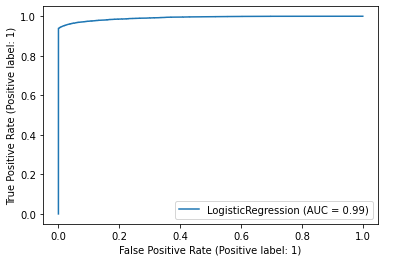

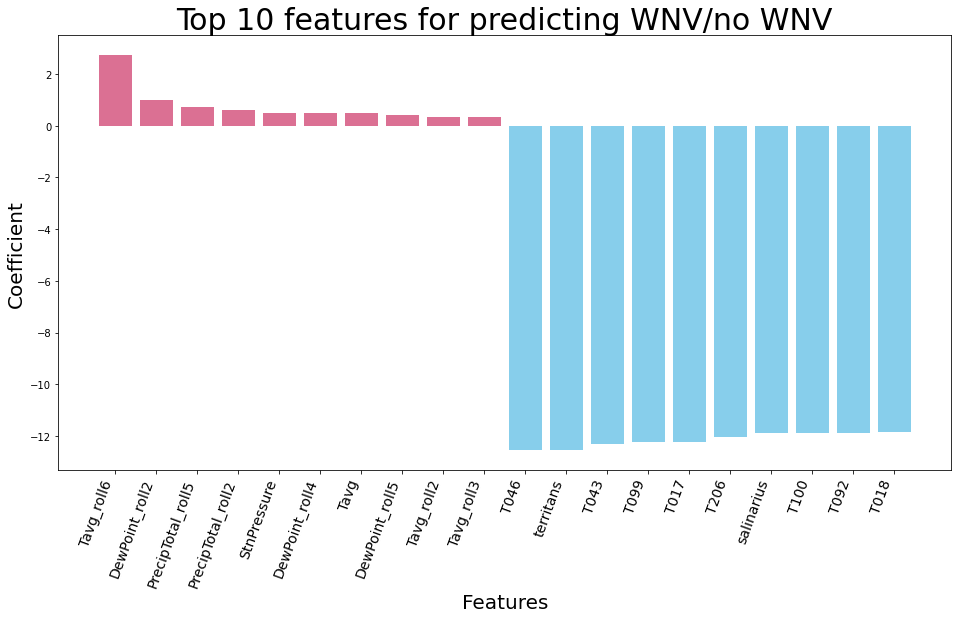

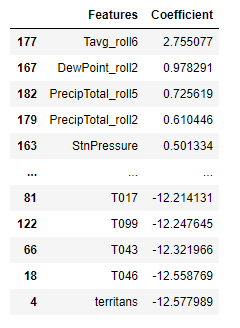

|        Model        	| Features used 	|      Scaling     	|                                   Best params                                   	| Accuracy 	|  Roc  	| Kaggle score 	|
|:-------------------:	|:-------------:	|:----------------:	|:-------------------------------------------------------------------------------:	|:--------:	|:-----:	|--------------	|
| Logistic Regression 	|  Default set  	| Standard & Smote 	| Tavg_roll6, DewPoint_roll2,  PrecipTotal_roll5,  PrecipTotal_roll2, StnPressure 	|   0.969  	| 0.992 	| 0.73467      	|

This is our model with the best Kaggle score of **0.73467**. Logistic regression performs well when the dataset is linearly separable and when there is average or no multicollinearity between independent variables and also the number of mosquitos is likely to follow a poisson distribution which the sigmoid logit link mapping perform well on.  We select the appropriate variables to be used through EDA and Lasso regularization and rolling the relevant weather factors according to the Culex lifecycle thus enabling us to get the best result from Logistic regression. 

We tried to improve the logistic regression score by using SelectKbest to further drop features but it turned out to perform worse most probably due to underfitting because of higher bias. The top 5 features being weather features do further strengthen our theory that weather is a strong predictor and rolling according to the Culex lifecycle is in the right direction.

## 8. Cost Analysis
---

In this section, we will summarize the impact spraying has on the average number of mosquitos and presence of West Nile Virus in the areas that have been sprayed. Then, we will proceed to identify the associated cost and benefits of spraying. Finally, we will propose a simple equation that can be used to evaluate whether an area should be sprayed.

For more information and details, please refer to the notebook, "Cost Benefit Analysis of Spraying.ipynb".

## A. Effects of Spraying on WNV

To view the effects of spraying, we will look at a few key data points. Data is segmented in order to see the impact spraying has on specific areas. Areas outside the spray area is taken as a 'control'. The timeframe of 10 days before and after spraying is used to study the effect of spraying on the average number of mosquitos and presence of West Nile Virus. This 10 days is derived from the mosquito lifecycle which span approximately 10 days.

### 7 September 2011
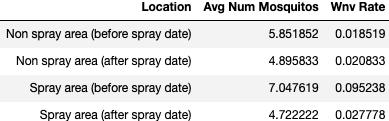

The table above is based on the spray date of 7 Sep 2011. We can see that there seems to be a reduction in the number of mosquitos and presence of West Nile Virus after spraying. For our control, we can see that the West Nile Virus infection detection rate increased very slightly but for the areas where spraying was done, we saw almost a 7% decrease in the West Nile Virus infection rate.

### 25 July 2013
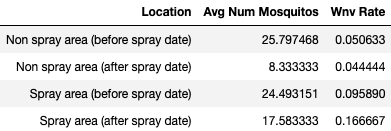

### 8 August 2013
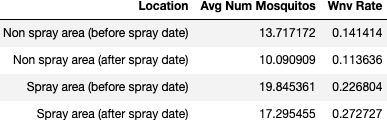

Looking at a few other spray dates, we can see that the effectiveness of spraying is not consistent. On certain dates, there is no significant reduction in the WNV rate. Furthermore, on some dates, there is an increase in WNV rates despite the presence of spraying. 

## B. Cost and Benefits of Spraying

To get a semblance of the cost and benefits of spraying, we first need to estimate the cost of West Nile Virus. [A paper](https://www.sciencedaily.com/releases/2014/02/140210184713.htm) released by the American Society of Tropical Medicine and Hygiene studied the the economic impact of West Nile virus in the United States across the span of 13 years from 1999 to 2012.

The 37,088 WNV disease cases reported to CDC from 1999 through 2012 included more than 16,000 patients with neurologic disease, over 18,000 patients who required hospitalization, and over 1,500 deaths. According to the CDC, individuals over 50 years of age are more likely to develop severe neurologic disease if infected. The total cost estimated was cumulative $778 million in health care expenditures and lost productivity.

This gives us an average cost of approximately $21,000 per case reported.

A [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/) published on the US National Library of Medicine stated 66 human cases of WNV for Chicago, Illinois in 2013. This brings the total cost to approximately $1,386,000.

The cost for spraying itself is not specified anywhere, however, the [2013 Chicago government budget](https://www.chicago.gov/content/dam/city/depts/obm/supp_info/2013%20Budget/2013Overview.pdf) listed the budget allocated to Environmental Health to be $1,191,811. This is defined as performing routine and complaint-generated inspections of facilities to ensure the City's ordinances related to environmental hazards are enforced. Coordinates mosquito surveillance and control activities and provides public education to reduce the risk of vector-borne diseases, principally the West Nile virus.

It is hard to do a dollar to dollar comparison of the cost/ benefit of spraying but we can construct a simple equation to estimate this.

## C. Cost and Benefits Equation

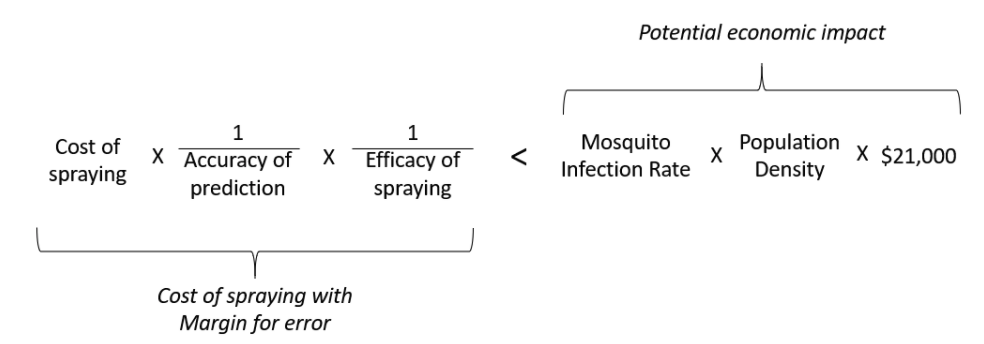

We propose a simple equation above as a guide to estimate the cost/benefits of spraying. From our modelling, we have a good sense of the accuracy of our prediction. [Mosquito infection rate](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/) and population density information is widely available.

The only pieces of information we will need is the actual dollar cost for spraying as well as an quantification of how effective the spray is at eradicating mosquitos and WNV. From our data, the results were inconclusive.

Based on the equation above, if the potential economic impact of mosquitos exceeds the total cost of spraying, then the area should be sprayed. We can run a quick calculation with ficticious numbers:

### Estimate the total cost of spraying

**Cost of spraying** = 500000

**Accuracy of prediction** = 0.73 (based on our selected model result)

**Efficacy of spraying** = 0.65

### Estimate the potential economic impact

**Mosquito infection rate** = 0.5%

**Population** = 10000

**Cost per case** = 21000 (provided by the study mentioned above)

### Total cost of spraying vs potential economic impact

Using the equation above and inputing the values as per indicated will give us the total cost of spraying which amounts to **$1,053,740.78**. 

Meanwhile, the potential economic impact will be **$1,050,000.00**.

Based on these values, we can see that the costs more or less even out and it will be up to the department of health to make a call in such instances. Our calculations also do not take into account the various intangible benefits and costs arising from spraying and the West Nile Virus. 

## 9. Conclusion and Recommendations
---

## A. Model Conclusion

Based on the models that we have tested, Logistic Regression is deemed to be the best model to predict the locations of West Nile Virus outbreaks in Chicago. This model has the highest Kaggle ROC score out of all the models that were tested.

Logistic Regression tends to perform well when the dataset is linearly separable and when there is average or no multicollinearity between independent variables. Additionally, the number of mosquitos is likely to follow a poisson distribution which the sigmoid logit link mapping perform well on. Moreover, the features that were used in the model were carefully selected via EDA and Lasso regularization. The relevant weather features were also rolled according to the Culex lifecycle. Thus, enabling us to get the best result from Logistic Regression. 

The top features for the Logistic Regression model include Tavg_roll6, DewPoint_roll2, PrecipTotal_roll5, PrecipTotal_roll2 and Stn Pressure. Weather features, specifically, the rolled weather features turned out to be some of the important features for the model. This observation can also be seen across all the other models that were tested. Hence, this confirms that rolling the relevant weather variables is a good strategy and that doing so helps to strengthen the result.

## B. Cost Benefit Analysis Conclusion

Based on looking at several key dates, for example, 7 September 2011, 25 July 2013 and 8 August 2013, we can see that the effect of spraying is not consistent. On 7 September 2011, the areas that were sprayed saw a significant drop in the average number of mosquitos and WNV rate. However, on 8 August 2013, the areas that were sprayed saw a huge increase in the WNV rate despite spraying while the average number of mosquitos in that area only marginally dropped.

To estimate the cost and benefit of spraying, we propose a simple equation (this is mentioned in detail in the Costs and Benefits Equation subsection above). 

### Total cost of spraying

Based on our equation, the total cost of spraying is dependent on 3 factors. These are:

- cost of spraying itself
- accuracy of prediction
- efficacy of prediction

We only have data for the accuracy of prediction (which is based on our model). Based on our research, there is no data for the specific cost of spraying in the Chicago areas. The relevant data that was found was the amount of budget allocated to Environmental Health in 2013, which was $1,191,811. This budget is used to perform routine and complaint-generated inspections of facilities to ensure the City's ordinances related to environmental hazards are enforced. The budget also covers coodination of mosquito surveillance and control activities.

### Potential Economic Impact of Spraying

Based on our equation, the potential economic impact of not spraying is dependent on 3 factors. These are:

- mosquito infection rate
- population density
- medical cost per case

Based on our research, we only have the value for the average medical cost per case, which amounts to $21,000.  

This value is derived from the total cost estimation of $778 million in health care expenditures and lost productivity based on the 37,088 WNV disease cases reported to CDC from 1999 through 2012.

### Conclusion

As some of the values, like explicit cost of spraying is not available, we used our proposed equation to calculate the cost and benefit of spraying after inputing actual and also fictitious numbers. Based on our calculation, the total cost of spraying is only slightly above the potential economic impact of not spraying. In such cases, it would be up to the Department of Health to make a call. 

One important thing to note is that our simple calculation do not include various intangible benefits and costs that are associated to spraying and West Nile Virus. 

## C. Recommendations

There are other "cheaper" ways for the government to help reduce the spread of WNV. The Chicago budget in 2013 showed $9,000,000 dedicated to community engaged care. This covers promoting health through education, policy and service. The government can ramp up education on West Nile Virus and how to prevent mosquito breeding. They can educate the public on preventing stagnant water, applying insect repellent, wearing the proper attire to reduce the chances of getting bitten by mosquitos.

Other measures which they have already undertaken but can place more emphasis on is the reporting of dead birds (a key in transmission of WNV), reporting on tall grass and weeds.

## 10. References and Data Sources
---

1. https://www.kaggle.com/c/predict-west-nile-virus/submit
2. https://www.sciencedaily.com/releases/2014/02/140210184713.htm
3. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/
4. https://www.chicago.gov/content/dam/city/depts/obm/supp_info/2013%20Budget/2013Overview.pdf
5. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/